In [23]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from mads_hackathon import datasets, metrics
import mltrainer
import tomllib

In [24]:
datadir = Path('../data/raw')
trainfile = (datadir / "heart_big_train.parq").resolve()
validfile = (datadir / "heart_big_valid.parq").resolve()
trainfile.exists(), validfile.exists()

(True, True)

In [25]:
class HeartDataset1DBalancer:
    def __init__(
        self,
        path: Path,
        target: str,
        balance: bool = True,
    ) -> None:
        self.df = pd.read_parquet(path)
        self.target = target
        _x = self.df.drop("target", axis=1)
        x = torch.tensor(_x.values, dtype=torch.float32)
        # padded to 3*2**6 = 192
        # again, this helps with reshaping for attention & using heads
        self.x = torch.nn.functional.pad(x, (0, 3 * 2**6 - x.size(1)))
        y = self.df["target"]
        self.y = torch.tensor(y.values, dtype=torch.int64)

        if balance:
            self._balance_classes()

    def _balance_classes(self):
        # Get unique classes and their counts
        unique_classes, class_counts = torch.unique(self.y, return_counts=True)
        max_count = torch.max(class_counts)
        
        # Initialize lists to store balanced data
        balanced_x = []
        balanced_y = []
        
        # Process each class
        for class_idx in unique_classes:
            # Get indices for current class
            class_mask = self.y == class_idx
            class_x = self.x[class_mask]
            class_y = self.y[class_mask]
            
            # Calculate number of repetitions needed
            current_count = class_counts[class_idx]
            multiplier = (max_count // current_count).item()
            remainder = (max_count % current_count).item()
            
            # Add repeated samples
            balanced_x.append(class_x.repeat(multiplier, 1))
            balanced_y.append(class_y.repeat(multiplier))
            
            # Add remainder samples if needed
            if remainder > 0:
                balanced_x.append(class_x[:remainder])
                balanced_y.append(class_y[:remainder])
        
        # Concatenate all balanced data
        self.x = torch.cat(balanced_x, dim=0)
        self.y = torch.cat(balanced_y, dim=0)
        
        # Shuffle the balanced dataset
        indices = torch.randperm(len(self.y))
        self.x = self.x[indices]
        self.y = self.y[indices]


    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int):
        # (seq_len, channels)
        return self.x[idx].unsqueeze(1), self.y[idx]

    def to(self, device):
        self.x = self.x.to(device)
        self.y = self.y.to(device)

    def __repr__(self) -> str:
        return f"Heartdataset (len {len(self)})"

In [26]:
traindataset = HeartDataset1DBalancer(trainfile, target="target", balance=False)
validdataset = datasets.HeartDataset1D(validfile, target="target")
traindataset, validdataset

# moving to mps device crashes the jypyter kernel, I wasnt able to fix that...

(Heartdataset (len 87554), Heartdataset (len 10946))

In [27]:
len(traindataset)

87554

In [28]:
traindataset

Heartdataset (len 87554)


Original Dataset:

Class Distribution:
----------------------------------------
Class      Count      Percentage
----------------------------------------
0          72471           82.77%
1          2223             2.54%
2          5788             6.61%
3          641              0.73%
4          6431             7.35%
----------------------------------------
Total samples: 87554

Imbalance Statistics:
Max class size: 72471
Min class size: 641
Imbalance ratio: 113.06

Balanced Dataset:

Class Distribution:
----------------------------------------
Class      Count      Percentage
----------------------------------------
0          72471           20.00%
1          72471           20.00%
2          72471           20.00%
3          72471           20.00%
4          72471           20.00%
----------------------------------------
Total samples: 362355

Imbalance Statistics:
Max class size: 72471
Min class size: 72471
Imbalance ratio: 1.00


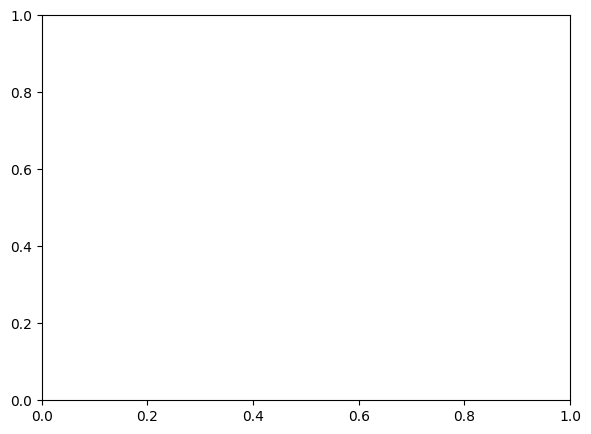

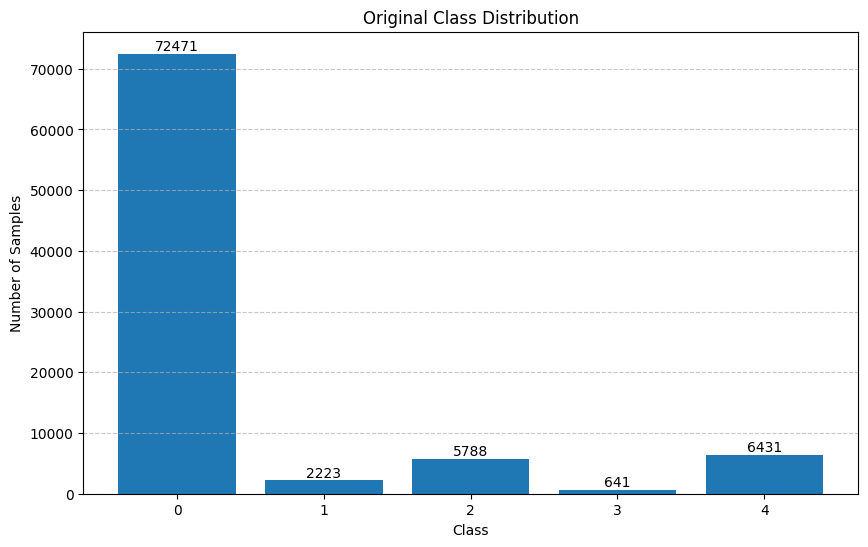

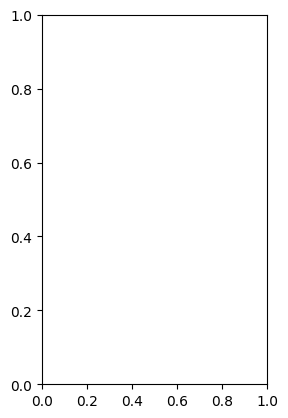

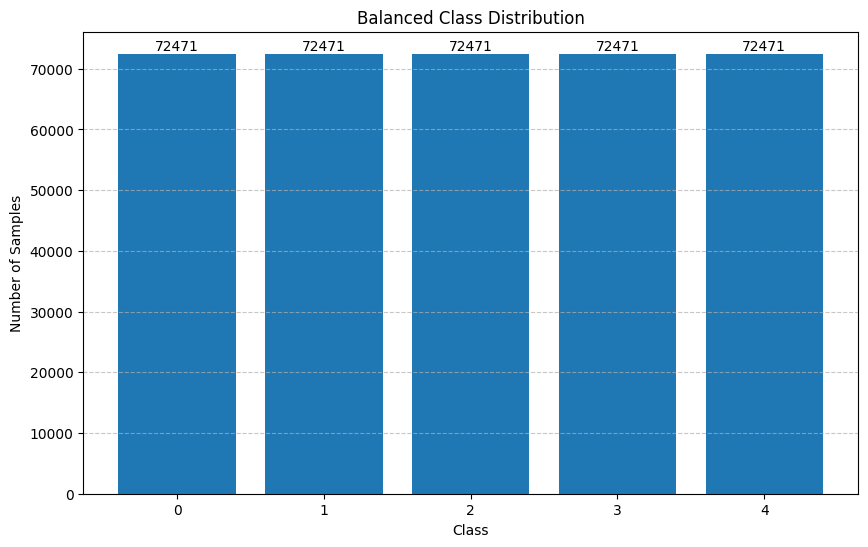

<Figure size 640x480 with 0 Axes>

In [29]:
def check_class_balance(dataset: HeartDataset1DBalancer) -> None:
    # Get class counts
    unique_classes, class_counts = torch.unique(dataset.y, return_counts=True)
    
    print("\nClass Distribution:")
    print("-" * 40)
    print(f"{'Class':<10} {'Count':<10} {'Percentage':>10}")
    print("-" * 40)
    
    total_samples = len(dataset)
    
    for class_idx, count in zip(unique_classes, class_counts):
        percentage = (count / total_samples) * 100
        print(f"{class_idx.item():<10} {count.item():<10} {percentage:>10.2f}%")
    
    print("-" * 40)
    print(f"Total samples: {total_samples}")
    
    # Calculate imbalance metrics
    max_count = torch.max(class_counts)
    min_count = torch.min(class_counts)
    imbalance_ratio = max_count / min_count
    
    print(f"\nImbalance Statistics:")
    print(f"Max class size: {max_count.item()}")
    print(f"Min class size: {min_count.item()}")
    print(f"Imbalance ratio: {imbalance_ratio:.2f}")

# Usage example:
def compare_balance(path: Path, target: str):
    # Check original dataset
    print("\nOriginal Dataset:")
    dataset_unbalanced = HeartDataset1DBalancer(path=path, target=target, balance=False)
    check_class_balance(dataset_unbalanced)
    
    # Check balanced dataset
    print("\nBalanced Dataset:")
    dataset_balanced = HeartDataset1DBalancer(path=path, target=target, balance=True)
    check_class_balance(dataset_balanced)


def visualize_class_distribution(dataset: HeartDataset1DBalancer, title: str = "Class Distribution"):
    import matplotlib.pyplot as plt
    
    # Get class counts
    unique_classes, class_counts = torch.unique(dataset.y, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    plt.bar(unique_classes.numpy(), class_counts.numpy())
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    
    # Add count labels on top of each bar
    for i, count in enumerate(class_counts):
        plt.text(i, count.item(), str(count.item()), 
                ha='center', va='bottom')
    
    plt.xticks(unique_classes.numpy())
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

def compare_distributions(path: Path, target: str):
    # Create datasets
    dataset_unbalanced = HeartDataset1DBalancer(path=path, target=target, balance=False)
    dataset_balanced = HeartDataset1DBalancer(path=path, target=target, balance=True)
    
    # Plot distributions
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    visualize_class_distribution(dataset_unbalanced, "Original Class Distribution")
    
    plt.subplot(1, 2, 2)
    visualize_class_distribution(dataset_balanced, "Balanced Class Distribution")
    
    plt.tight_layout()
    plt.show()

# Use both numerical and visual checks
path = Path(trainfile)
compare_balance(path, target="target")
compare_distributions(path, target="target")

In [30]:



class HeartDataset2DBalancer:
    def __init__(
        self,
        path: Path,
        target: str,
        shape: tuple[int, int] = (16, 12),
        balance: bool = True,
    ) -> None:
        self.df = pd.read_parquet(path)
        self.target = target
        _x = self.df.drop("target", axis=1)
        self.x = torch.tensor(_x.values, dtype=torch.float32)



        y = self.df["target"]
        self.y = torch.tensor(y.values, dtype=torch.int64)


        if balance:
            self._balance_classes()

        # original length is 187, which only allows for 11x17 2D tensors
        # 3*2**6 = 192. This makes it easier to reshape the data
        # it also makes convolutions / maxpooling more predictable
        self.x = torch.nn.functional.pad(self.x, (0, 3 * 2**6 - self.x.size(1))).reshape(
            -1, 1, *shape
        )



    def _balance_classes(self):
        # Get unique classes and their counts
        unique_classes, class_counts = torch.unique(self.y, return_counts=True)
        max_count = torch.max(class_counts)
        
        # Initialize lists to store balanced data
        balanced_x = []
        balanced_y = []
        
        # Process each class
        for class_idx in unique_classes:
            # Get indices for current class
            class_mask = self.y == class_idx
            class_x = self.x[class_mask]
            class_y = self.y[class_mask]
            
            # Calculate number of repetitions needed
            current_count = class_counts[class_idx]
            multiplier = (max_count // current_count).item()
            remainder = (max_count % current_count).item()
            
            # Add repeated samples
            balanced_x.append(class_x.repeat(multiplier, 1))
            balanced_y.append(class_y.repeat(multiplier))
            
            # Add remainder samples if needed
            if remainder > 0:
                balanced_x.append(class_x[:remainder])
                balanced_y.append(class_y[:remainder])
        
        # Concatenate all balanced data
        self.x = torch.cat(balanced_x, dim=0)
        self.y = torch.cat(balanced_y, dim=0)
        
        # Shuffle the balanced dataset
        indices = torch.randperm(len(self.y))
        self.x = self.x[indices]
        self.y = self.y[indices]


    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

    def to(self, device):
        self.x = self.x.to(device)
        self.y = self.y.to(device)

    def __repr__(self) -> str:
        return f"Heartdataset2D (#{len(self)})"

In [31]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_sizes=[64, 128], dropout=0.2):
        super(RNNModel, self).__init__()
        
        self.masking = None  # PyTorch handles masking differently
        self.hidden_sizes = hidden_sizes
        
        # Create Bidirectional GRU layers
        self.gru_layers = nn.ModuleList()
        input_size_gru = input_size
        
        for i, hidden_size in enumerate(hidden_sizes):
            gru_layer = nn.GRU(
                input_size=input_size_gru,
                hidden_size=hidden_size,
                batch_first=True,
                dropout=dropout if i < len(hidden_sizes) - 1 else 0,
                bidirectional=True
            )
            self.gru_layers.append(gru_layer)
            input_size_gru = hidden_size * 2  # * 2 because of bidirectional
        
        # Dense layers
        self.dense1 = nn.Linear(hidden_sizes[-1] * 2, 64)  # * 2 because of bidirectional
        self.dense2 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 5)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        
        # Process through GRU layers
        current_layer = x
        for i, gru_layer in enumerate(self.gru_layers):
            current_layer, _ = gru_layer(current_layer)
            if i < len(self.gru_layers) - 1:
                # Keep all sequences for non-final layers
                pass
            else:
                # For the last GRU layer, only keep the last output
                current_layer = current_layer[:, -1, :]
        
        # Dense layers
        current_layer = self.relu(self.dense1(current_layer))
        current_layer = self.relu(self.dense2(current_layer))
        logits = self.relu(self.output(current_layer))
        
        return logits
    
    def parameter_count(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Example usage:
def create_model(sequence_length=187):
    model = RNNModel(
        input_size=1,
        hidden_sizes=[64, 128],
        dropout=0.2
    )
    
    print('Parameter count:', model.parameter_count())
    
    # If you want to see the model structure:
    print("\nModel structure:")
    print(model)
    
    # Test the model with dummy data
    batch_size = 32
    x = torch.randn(batch_size, sequence_length, 1)
    output = model(x)
    print("\nOutput shape:", output.shape)  # Should be (batch_size, 5)
    
    return model


model = create_model()

Parameter count: 241445

Model structure:
RNNModel(
  (gru_layers): ModuleList(
    (0): GRU(1, 64, batch_first=True, dropout=0.2, bidirectional=True)
    (1): GRU(128, 128, batch_first=True, bidirectional=True)
  )
  (dense1): Linear(in_features=256, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=5, bias=True)
  (relu): ReLU()
)

Output shape: torch.Size([32, 5])


/Users/tijsvandervelden/Development/hackathon/hackathon/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [ ]:
from mads_hackathon.models import TransformerConfig as Config

config = Config(
    batchsize=128,
    dropout=0.1,
    input_channels=1,
    hidden=64,
    kernel_size=3,
    stride=1,
    num_heads=2,
    num_blocks=2,
    num_classes=5,
)

from mads_hackathon.metrics import caluclate_cfm
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()



from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict
loss_fn = torch.nn.CrossEntropyLoss()

#
optimizer = torch.optim.Adam

settings = TrainerSettings(
    epochs=5,
    metrics=[accuracy, f1micro, f1macro, precision, recall],
    logdir="logs/heart1D",
    train_steps=len(trainstreamer),
    valid_steps=len(validstreamer),
    reporttypes=[ReportTypes.TENSORBOARD],
    scheduler_kwargs=None,
    earlystop_kwargs=None
)

# mlflow.set_tag("model", "Transfomer")
# mlflow.set_tag("dataset", "heart1D")
# mlflow.log_params(asdict(config))
# mlflow.log_param("epochs", settings.epochs)
# mlflow.log_param("optimizer", str(optimizer))
# mlflow.log_param("scheduler", "None")
# mlflow.log_param("earlystop", "None")
# mlflow.log_params(settings.optimizer_kwargs)

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optimizer,
    traindataloader=trainstreamer.stream(),
    validdataloader=validstreamer.stream(),
    device="mps",
    scheduler=None,
    )
trainer.loop()
cfm = caluclate_cfm(model, teststreamer)
#     for i, tp in enumerate(np.diag(cfm)):
#         mlflow.log_metric(f"TP_{i}", tp)
# plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
# plot.set(xlabel="Predicted", ylabel="Target")

2024-11-25 12:39:59.638 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20241125-123959
  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
import tempfile

import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torchvision
from dotenv import load_dotenv
from mads_datasets import DatasetFactoryProvider, DatasetType
from torch import optim
from torch.nn import CrossEntropyLoss
from torcheval.metrics import MulticlassAccuracy
from torchvision import transforms
from torchvision.models import ResNet18_Weights
from tytorch.trainer import Trainer
from tytorch.utils.mlflow import set_mlflow_experiment
from tytorch.utils.trainer_utils import get_device

load_dotenv()
params = {"n_epochs": 2, "lr": 0.1, "batchsize":128}
device = get_device()

trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=params["batchsize"])
validstreamer = BaseDatastreamer(validdataset, preprocessor = BasePreprocessor(), batchsize=params["batchsize"])
len(trainstreamer), len(validstreamer)



optimizer = optim.SGD(
    model.parameters(), lr=params["lr"], weight_decay=1e-05, momentum=0.9
)

trainer = Trainer(
    model=model,
    loss_fn=CrossEntropyLoss(),
    metrics=[MulticlassAccuracy()],
    optimizer=optimizer,
    device=device,
    train_steps=len(traindataset),
    valid_steps=len(validdataset),
    lrscheduler=optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1),
    quiet=True
)


set_mlflow_experiment(
    "train", True, tracking_uri="http://madsmlflowwa.azurewebsites.net"
)
with mlflow.start_run():
    mlflow.log_params(params)
    trainer.fit(params["n_epochs"], trainstreamer, validstreamer)

    with tempfile.TemporaryDirectory() as path:
        model_path = f"{path}/bigru.pth"
        torch.save(model.state_dict(), model_path)
        mlflow.log_artifact(path)

mlflow.end_run()


2024-11-25 12:28:25.475 | INFO     | tytorch.utils.trainer_utils:get_device:12 - Using MPS
2024/11/25 12:28:25 INFO mlflow.tracking.fluent: Experiment with name 'train-2024-11-25-12:28:25' does not exist. Creating a new experiment.
2024/11/25 12:28:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-hen-966 at: http://madsmlflowwa.azurewebsites.net/#/experiments/49/runs/d6d92e968c8f4daaaaebd60b43565f36.
2024/11/25 12:28:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://madsmlflowwa.azurewebsites.net/#/experiments/49.


TypeError: 'BaseDatastreamer' object is not iterable